In [1]:
!pip install threadpoolctl==3.1.0

In [72]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [74]:
# Read in Data
district_facts = pd.read_excel("data/raw data/DistrictFastFacts_20232024.xlsx")
internet_access = pd.read_csv("data/raw data/DistrictMap.csv", encoding="utf-16", delimiter = "\t")

In [76]:
# Create column to join on 
district_facts["name"] = district_facts["DistrictName"].str.replace("SD", "School District")

In [78]:
# Merge Data 
joined_data = district_facts.merge(internet_access, on = "name", how = "left")
joined_data.head()

,DistrictName,AUN,DistrictAddress,DistrictAddressCity,DistrictAddressState,DistrictZipCode,Website,TelephoneNumber,NumberofSchools,GradesOffered,...,name,nces_code,district_id,county_name,city,locale,Max. frl_percent,num_students,perc_unconnected_students,sum_unconnected_students
0,Abington SD,123460302,970 Highland Ave,Abington,PA,19001,http://www.abington.k12.pa.us,215-884-4700,9,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Abington School District,4202040.0,953602.0,Montgomery County,ABINGTON,Suburban,26%,"8,126",9%,745
1,Abington Heights SD,119350303,200 E Grove St,Clarks Summit,PA,18411,http://www.ahsd.org,570-586-2511,6,"K5H, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Abington Heights School District,4202010.0,953601.0,Lackawanna County,CLARKS SUMMIT,Rural,20%,"3,304",7%,231
2,Albert Gallatin Area SD,101260303,2625 Morgantown Rd,Uniontown,PA,15401,http://www.agasd.org,724-564-7190,8,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Albert Gallatin Area School District,4202100.0,953603.0,Fayette County,UNIONTOWN,Rural,84%,"3,416",29%,"1,005"
3,Aliquippa SD,127040503,800 21st Street,Aliquippa,PA,15001,http://www.quipsd.org,724-857-7500,2,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Aliquippa School District,4202130.0,953604.0,Beaver County,ALIQUIPPA,Suburban,100%,"1,077",35%,377
4,Allegheny Valley SD,103020603,300 Pearl Ave,Cheswick,PA,15024,http://www.avsdweb.org,724-274-5300,2,"PreKF, K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12",...,Allegheny Valley School District,4202190.0,953605.0,Allegheny County,CHESWICK,Suburban,47%,943,17%,156


In [80]:
# Select relevant columns 
cols = ["name", "NumberofSchools", "GradesOffered", "DistrictEnrollment", "PercentofGiftedStudents",
        "CharterSchoolEnrollment", "GeographicSizeofDistrict", "AmericanIndian_AlaskanNative", "Asian", "NativeHawaiianorotherPacificIslander",
       "Black", "Hispanic", "White", "TwoOrMoreRaces", "EconomicallyDisadvantaged", "EnglishLearner", "SpecialEducation", "Female", "Male", 
       "Homeless", "MilitaryConnected", "perc_unconnected_students", "Latitude", "Longitude"]
joined_data = joined_data[cols]

In [82]:
# Recode percentages
joined_data["perc_unconnected_students"] = joined_data["perc_unconnected_students"].str.rstrip('%').astype(float)

In [84]:
# Scale Numerical Features
num_features = ["DistrictEnrollment", "PercentofGiftedStudents", "CharterSchoolEnrollment", "GeographicSizeofDistrict", 
                "AmericanIndian_AlaskanNative", "Asian", "NativeHawaiianorotherPacificIslander", "Black", "Hispanic", "White", "TwoOrMoreRaces",
                "EconomicallyDisadvantaged", "EnglishLearner", "SpecialEducation", "Female", "Male", "Homeless", 
                "MilitaryConnected", "perc_unconnected_students"]

scaler = StandardScaler()

joined_data[num_features] = scaler.fit_transform(joined_data[num_features])  # Apply scaling

joined_data = joined_data.dropna()

In [86]:
joined_data.to_csv("district_data.csv")

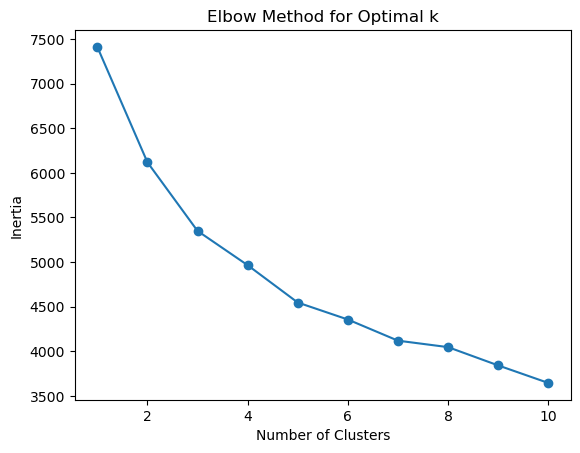

In [9]:
# Calculate the distortion (inertia) for different values of k to select optimal number of clusters 
inertia = []
k_range = range(1, 11)  # You can test k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(joined_data[num_features])
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [10]:
# Apply K-Means with the chosen number of clusters (let’s say k=4)
k = 4  # Replace with your chosen k
kmeans = KMeans(n_clusters=k, random_state=42)
joined_data['Cluster'] = kmeans.fit_predict(joined_data[num_features])

In [11]:
# Analyze the average values of features for each cluster
cluster_summary = joined_data.groupby('Cluster')[num_features].mean()
print(cluster_summary)

         DistrictEnrollment  PercentofGiftedStudents  CharterSchoolEnrollment  \
Cluster                                                                         
0                  0.332511                 1.403916                -0.057917   
1                 -0.153987                -0.208823                -0.067076   
2                  0.153181                -0.435694                 0.062003   
3                 -0.253763                -0.382492                -0.069245   

         GeographicSizeofDistrict  AmericanIndian_AlaskanNative     Asian  \
Cluster                                                                     
0                       -0.502772                     -0.003023  1.303343   
1                        0.084912                     -0.052454 -0.333190   
2                       -0.568817                      0.458908 -0.178586   
3                        0.635838                     -0.109949 -0.445501   

         NativeHawaiianorotherPacificIslander     

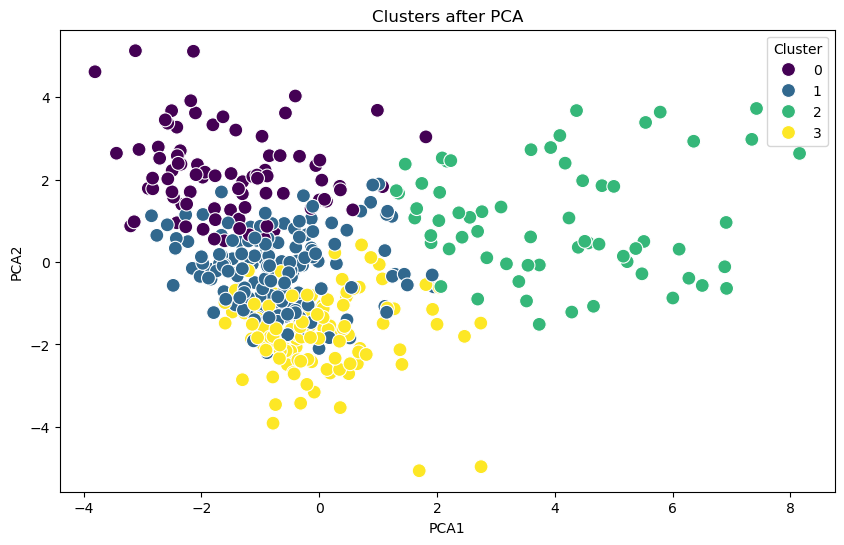

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(joined_data[num_features])

# Add PCA components to the dataframe
joined_data['PCA1'] = pca_components[:, 0]
joined_data['PCA2'] = pca_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=joined_data, s=100)
plt.title('Clusters after PCA')
plt.show()

Cluster Centers (Centroids):
   DistrictEnrollment  PercentofGiftedStudents  CharterSchoolEnrollment  \
0            0.332511                 1.403916                -0.057917   
1           -0.153987                -0.208823                -0.067076   
2            0.153181                -0.435694                 0.062003   
3           -0.253763                -0.382492                -0.069245   

   GeographicSizeofDistrict  AmericanIndian_AlaskanNative     Asian  \
0                 -0.502772                     -0.003023  1.303343   
1                  0.084912                     -0.052454 -0.333190   
2                 -0.568817                      0.458908 -0.178586   
3                  0.635838                     -0.109949 -0.445501   

   NativeHawaiianorotherPacificIslander     Black  Hispanic     White  \
0                              0.004960 -0.145651  0.037183 -0.212274   
1                              0.182829 -0.307728 -0.208511  0.420868   
2                   

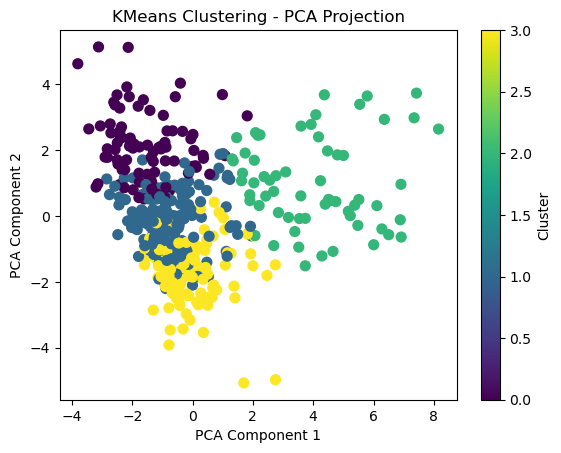

In [13]:
joined_data['Cluster'] = kmeans.labels_

# Step 1: Display the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=num_features)
print("Cluster Centers (Centroids):")
print(cluster_centers)

# Step 2: Summarize each cluster (mean and standard deviation for each feature)
cluster_summary = joined_data.groupby('Cluster')[num_features].agg(['mean', 'std'])
print("\nCluster Summary (Mean and Std Dev):")
print(cluster_summary)

# Step 3: Count number of samples in each cluster
cluster_counts = joined_data['Cluster'].value_counts()
print("\nCluster Sizes (Number of Samples in Each Cluster):")
print(cluster_counts)

# Optional: You can visualize the clusters by reducing dimensionality (e.g., PCA or t-SNE)
# Example: Dimensionality Reduction with PCA for visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(joined_data[num_features])

# Plot the clusters
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=joined_data['Cluster'], cmap='viridis', s=50)
plt.title('KMeans Clustering - PCA Projection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Cluster Centers (Centroids):
   DistrictEnrollment  PercentofGiftedStudents  CharterSchoolEnrollment  \
0            0.332511                 1.403916                -0.057917   
1           -0.153987                -0.208823                -0.067076   
2            0.153181                -0.435694                 0.062003   
3           -0.253763                -0.382492                -0.069245   

   GeographicSizeofDistrict  AmericanIndian_AlaskanNative     Asian  \
0                 -0.502772                     -0.003023  1.303343   
1                  0.084912                     -0.052454 -0.333190   
2                 -0.568817                      0.458908 -0.178586   
3                  0.635838                     -0.109949 -0.445501   

   NativeHawaiianorotherPacificIslander     Black  Hispanic     White  \
0                              0.004960 -0.145651  0.037183 -0.212274   
1                              0.182829 -0.307728 -0.208511  0.420868   
2                   

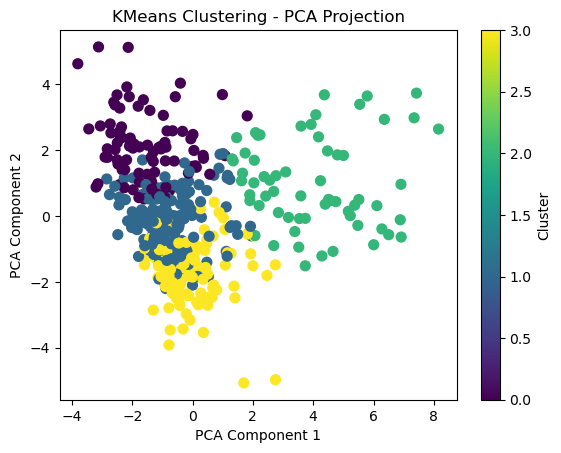

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Assuming kmeans has been fitted and 'joined_data' is your DataFrame

# Step 1: Add the cluster labels to your DataFrame
joined_data['Cluster'] = kmeans.labels_

# Step 2: Calculate the cluster centers (centroids) and show them
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=num_features)
print("Cluster Centers (Centroids):")
print(cluster_centers)

# Step 3: Calculate summary statistics for each cluster (mean and std deviation)
cluster_summary = joined_data.groupby('Cluster')[num_features].agg(['mean', 'std'])
print("\nCluster Summary (Mean and Std Dev):")
print(cluster_summary)

# Step 4: Descriptive interpretation based on specific features
# Let's focus on demographic features, enrollment, and internet access
# You can use the summary to interpret key features per cluster:

# Example: Demographic Features
demographics = ['AmericanIndian_AlaskanNative', 'Asian', 'NativeHawaiianorotherPacificIslander', 
                'Black', 'Hispanic', 'White', 'TwoOrMoreRaces']

# Enrollment and Access features
enrollment_access = ['DistrictEnrollment', 'PercentofGiftedStudents', 'CharterSchoolEnrollment', 
                     'EconomicallyDisadvantaged', 'EnglishLearner', 'SpecialEducation', 
                     'Female', 'Male', 'Homeless', 'MilitaryConnected', 'perc_unconnected_students']

# Now print the cluster mean for these specific features
print("\nDemographic Features Mean by Cluster:")
print(joined_data.groupby('Cluster')[demographics].mean())

print("\nEnrollment and Access Features Mean by Cluster:")
print(joined_data.groupby('Cluster')[enrollment_access].mean())

# Step 5: Visualize the clusters (Optional for better understanding)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(joined_data[num_features])

# Plot the clusters
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=joined_data['Cluster'], cmap='viridis', s=50)
plt.title('KMeans Clustering - PCA Projection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [15]:
cluster_summary = joined_data.groupby('Cluster')[num_features].agg(['mean', 'std'])

# Step 2: Flatten the multi-level columns for easy readability
cluster_summary.columns = [f"{col[0]}_{col[1]}" for col in cluster_summary.columns]

# Step 3: Round the summary statistics for better readability
cluster_summary = cluster_summary.round(2)

# Step 4: Optionally, apply color coding for better comparison
# Highlight higher values with a gradient color scheme
styled_summary = cluster_summary.style.background_gradient(cmap='YlGnBu', axis=None)

# Step 5: Show the styled summary table
styled_summary

,DistrictEnrollment_mean,DistrictEnrollment_std,PercentofGiftedStudents_mean,PercentofGiftedStudents_std,CharterSchoolEnrollment_mean,CharterSchoolEnrollment_std,GeographicSizeofDistrict_mean,GeographicSizeofDistrict_std,AmericanIndian_AlaskanNative_mean,AmericanIndian_AlaskanNative_std,Asian_mean,Asian_std,NativeHawaiianorotherPacificIslander_mean,NativeHawaiianorotherPacificIslander_std,Black_mean,Black_std,Hispanic_mean,Hispanic_std,White_mean,White_std,TwoOrMoreRaces_mean,TwoOrMoreRaces_std,EconomicallyDisadvantaged_mean,EconomicallyDisadvantaged_std,EnglishLearner_mean,EnglishLearner_std,SpecialEducation_mean,SpecialEducation_std,Female_mean,Female_std,Male_mean,Male_std,Homeless_mean,Homeless_std,MilitaryConnected_mean,MilitaryConnected_std,perc_unconnected_students_mean,perc_unconnected_students_std
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.330000,0.510000,1.400000,1.180000,-0.060000,0.040000,-0.500000,0.310000,-0.000000,0.480000,1.300000,1.440000,0.000000,0.640000,-0.150000,0.290000,0.040000,0.540000,-0.210000,0.490000,0.110000,0.540000,-1.190000,0.680000,0.290000,0.670000,-0.720000,0.790000,0.160000,0.620000,-0.160000,0.630000,-0.530000,0.470000,0.160000,0.870000,-1.090000,0.470000
1,-0.150000,0.260000,-0.210000,0.620000,-0.070000,0.020000,0.080000,0.760000,-0.050000,0.580000,-0.330000,0.280000,0.180000,1.310000,-0.310000,0.260000,-0.210000,0.570000,0.420000,0.460000,-0.340000,0.540000,-0.050000,0.690000,-0.320000,0.410000,-0.140000,0.880000,0.650000,0.700000,-0.640000,0.710000,-0.170000,0.680000,0.120000,1.260000,-0.210000,0.580000
2,0.150000,0.690000,-0.440000,0.720000,0.060000,0.260000,-0.570000,0.630000,0.460000,2.460000,-0.180000,0.560000,-0.070000,0.860000,1.610000,1.740000,1.190000,1.820000,-1.820000,0.890000,1.440000,1.550000,1.310000,0.800000,1.140000,1.790000,0.650000,1.140000,-0.210000,0.910000,0.210000,0.910000,0.860000,1.330000,-0.340000,0.420000,1.550000,0.870000
3,-0.250000,0.180000,-0.380000,0.560000,-0.070000,0.030000,0.640000,1.440000,-0.110000,0.450000,-0.450000,0.160000,-0.210000,0.700000,-0.390000,0.180000,-0.360000,0.400000,0.580000,0.350000,-0.410000,0.560000,0.170000,0.470000,-0.420000,0.330000,0.360000,0.860000,-0.930000,0.900000,0.930000,0.910000,0.170000,1.120000,-0.100000,0.760000,0.210000,0.640000


Key Takeaways:
- Cluster 0: Likely represents smaller, more homogenous districts with lower diversity.
- Cluster 1: Larger districts with high proportions of Black students, English Learners, and Special Education students. There’s more variation in many features, especially homelessness and special education.
- Cluster 2: Includes districts with a higher proportion of American Indian/Alaskan Native and Hispanic students, but low gifted student percentages and a focus on English Learners.
- Cluster 3: Smaller districts with more White students, relatively balanced gender, and significant Special Education and Military-Connected student populations.
- Cluster 4: Larger districts with high gifted student percentages and a slightly higher proportion of White students, but with some imbalance in Special Education and English Learners.

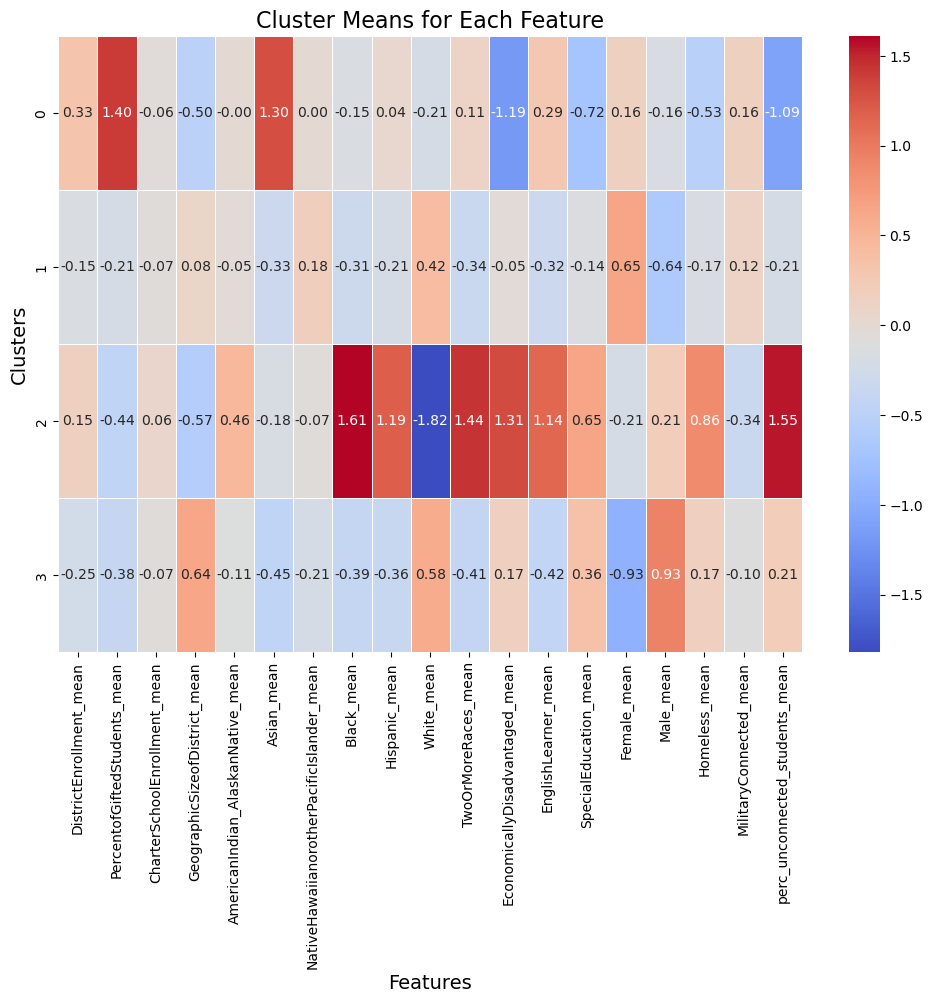

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the mean columns (assuming '_mean' suffix for mean columns)
mean_columns = [col for col in cluster_summary.columns if '_mean' in col]

# Create the 'cluster_means_df' DataFrame with the cluster labels as index
cluster_means_df = cluster_summary[mean_columns]

# Assuming 'cluster_means_df' contains the mean values for each cluster across the features
# Create a heatmap of the mean values for each cluster and feature
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Customize plot
plt.title('Cluster Means for Each Feature', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.show()


1. Cluster Profiles Based on Demographics:
Cluster 0:
Demographics: Generally balanced with a slight tilt toward Asian students (positive mean for Asian), but lower Black and Hispanic populations.
Enrollment: Moderate enrollment (positive value for DistrictEnrollment), high gifted students (PercentofGiftedStudents).
Access: Slightly below-average economically disadvantaged students and low special education enrollment.
Cluster 1:
Demographics: Predominantly White and fewer Hispanic students.
Enrollment: Lower-than-average district enrollment and fewer gifted students, with low charter school enrollment.
Access: Relatively more economically disadvantaged students, moderate levels of special education.
Cluster 2:
Demographics: Very high representation of Black and Hispanic students (Black and Hispanic features have positive means).
Enrollment: Moderate enrollment and few gifted students.
Access: High percentage of economically disadvantaged and English learners, indicating a lower-income and diverse community.
Cluster 3:
Demographics: High proportion of White and male students, but low percentages of economically disadvantaged and English learner students.
Enrollment: Low enrollment overall, fewer gifted students, with more charter school enrollment compared to other clusters.
Access: Relatively few economically disadvantaged students, low special education enrollment.
2. Enrollment and Access Insights:
Gifted students: Cluster 0 has the highest percentage of gifted students, while Cluster 2 has the lowest.
Charter school enrollment: Cluster 0 and Cluster 3 show low charter school enrollment, while Cluster 2 has slightly higher.
Economically Disadvantaged Students: Cluster 2 has the highest percentage of economically disadvantaged students, while Cluster 1 has the lowest.
English Learners: Cluster 2 has a notably high percentage of English learners, while Cluster 1 has the lowest.
3. Gender Distribution:
Cluster 0: Slightly more female students.
Cluster 1: More females, with a strong male underrepresentation.
Cluster 2: Balanced gender distribution with slight male overrepresentation.
Cluster 3: Strong male overrepresentation.
4. Homelessness and Military Connection:
Cluster 0: High levels of homelessness.
Cluster 1: Low levels of homelessness.
Cluster 2: High levels of homelessness and a relatively low percentage of military-connected students.
Cluster 3: Moderate homelessness levels, with a lower military-connected student percentage than Cluster 0.
5. Special Education:
Cluster 2 and Cluster 3 have the highest mean for special education, indicating a higher need for such services.
Cluster 1 has the lowest, suggesting fewer students needing special education services.
6. Geographic Size:
Cluster 3 stands out for having the largest districts geographically (positive mean for GeographicSizeofDistrict).
Cluster 0 and Cluster 2 represent smaller districts.
Conclusion:
Cluster 0: More affluent and Asian-dominated schools with high percentages of gifted students but low diversity in terms of race and economic background.
Cluster 1: More suburban or affluent schools, low diversity, with fewer challenges (economically disadvantaged, special education).
Cluster 2: Very diverse, with high numbers of Black and Hispanic students, high economically disadvantaged and special education needs, and higher numbers of English learners.
Cluster 3: Smaller, rural or suburban districts with higher proportions of White students, higher male representation, and fewer economically disadvantaged students but moderate special education needs.
These insights can help tailor education policies or interventions by cluster, based on specific needs related to enrollment trends, demographics, and access to resources.

In [54]:
joined_data.groupby('Cluster').sum()

,name,NumberofSchools,GradesOffered,DistrictEnrollment,PercentofGiftedStudents,CharterSchoolEnrollment,GeographicSizeofDistrict,AmericanIndian_AlaskanNative,Asian,NativeHawaiianorotherPacificIslander,...,EconomicallyDisadvantaged,EnglishLearner,SpecialEducation,Female,Male,Homeless,MilitaryConnected,perc_unconnected_students,PCA1,PCA2
Cluster,,,,,,,,,,,,,,,,,,,,,
0,Abington School DistrictAbington Heights Schoo...,571,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12K5H,...",27.598390,116.524994,-4.807150,-41.730100,-0.250903,108.177444,0.411662,...,-98.673162,24.415018,-60.121913,13.110737,-12.947483,-44.010322,13.054320,-90.472074,-126.745115,178.607107
1,Albert Gallatin Area School DistrictArmstrong ...,710,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12K5H,...",-25.869868,-35.082316,-11.268738,14.265299,-8.812299,-55.975994,30.715342,...,-8.695412,-54.504801,-24.029579,108.407616,-108.288344,-28.438016,19.760542,-34.670558,-119.384868,-38.526284
2,Aliquippa School DistrictAntietam School Distr...,414,"K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12K5F,...",9.650419,-27.448704,3.906173,-35.835487,28.911228,-11.250949,-4.669677,...,82.540639,71.789320,41.241291,-12.989598,13.047003,54.206710,-21.214026,97.908349,252.678236,63.360839
3,Allegheny Valley School DistrictAllegheny-Clar...,417,"PreKF, K5F, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...",-30.705283,-46.281529,-8.378698,76.936403,-13.303863,-53.905675,-25.569569,...,20.191499,-51.421223,43.694973,-112.308105,112.024952,20.187116,-11.791621,25.973464,-6.548252,-203.441662


In [ ]:
joined_